In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar
from scipy.integrate import odeint

In [2]:
r_R = 1000801.0
m_R = 4.076481530906363e+33
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
l=2 
nl = (l-1)*(l+2)/2
def _b(r, M):
    return (G*M)/((c**2)*r)

In [3]:
def V_z(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    fac = (1-2*b)
    num = 2*(n**2)*(n+1) + 6*(n**2)*b + 18*n*(b**2) + 18*(b**3)
    dem = (r**2) * (n+3*b)**2
    return fac * num/dem

def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def zerilli(u, r, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z(r, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

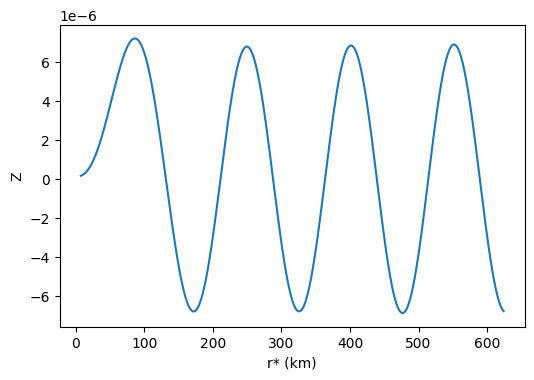

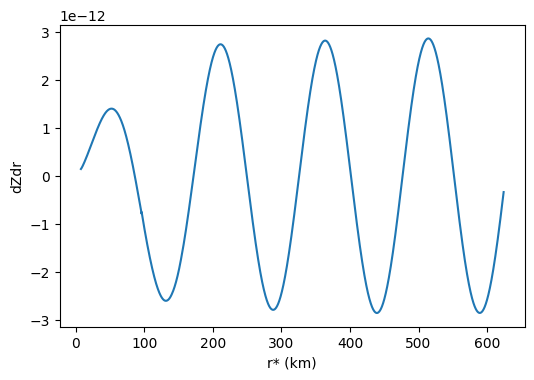

[ 1.57000000e-07  1.58086769e-07  1.59180538e-07 ... -6.77852671e-06
 -6.77953551e-06 -6.78053384e-06]


In [4]:
omega = 2e3*2*np.pi
z0 = [1.57e-07, 1.46e-13]

# From surface to inf
r_vals = np.linspace(r_R, 25 * c / omega, 20000)
r_star_vals = r_star_func(r_vals, m_R)
sol = odeint(zerilli, y0 = z0, t = r_star_vals, args = (omega,))
z, dzdr_star = sol.T

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, z)
plt.xlabel("r* (km)")
plt.ylabel("Z")
plt.show()

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, dzdr_star)
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
plt.show()

print(z)

In [5]:
# # 1983 Version
def r_star_func(r, m_R):
    return r + 2 * (G/(c**2)) * m_R * np.log(abs((r*(c**2))/(2*G*m_R) - 1))

def V_z2(r, m_R, nl):
    G_c2 = G/(c**2)
    num = (1-2*G_c2*m_R/r)
    dem = (r**3)*((nl*r+3*G_c2*m_R)**2)
    fac1 = 2*nl**2*(nl+1)*(r**3)
    fac2 = 6*(G_c2**1)*(nl**2)*m_R*(r**2)
    fac3 = 18*(G_c2**2)*nl*(m_R**2)*r
    fac4 = 18*(G_c2**3)*(m_R**3)
    fac = fac1 + fac2 + fac3 + fac4
    ret = fac * num/dem
    return ret

def zerilli3(u, r_star, omega):
    z, dZdr_star = u
    m = m_R
    d2Zdr2_star = z * (V_z2(r_star, m_R, nl) - omega*np.conj(omega)/(c**2))
    ret = [dZdr_star, d2Zdr2_star] # dZ/dr*, d2Z/dr*2
    return ret 

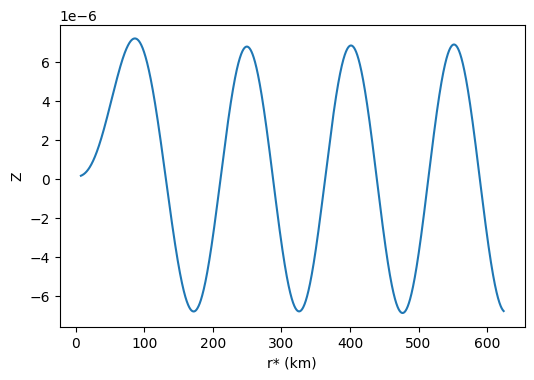

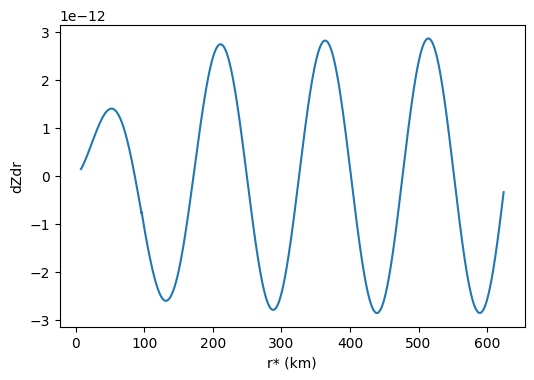

[ 1.57000000e-07  1.61389410e-07  1.65886948e-07 ... -6.77249845e-06
 -6.77674211e-06 -6.78081841e-06]


In [6]:
omega = 2e3*2*np.pi
z0 = [1.57e-07, 1.46e-13]

# From surface to inf
r_vals = np.linspace(r_R, 25 * c / omega, 5000)
r_star_vals = r_star_func(r_vals, m_R)
sol = odeint(zerilli3, y0 = z0, t = r_star_vals, args = (omega,))

z, dzdr_star = sol.T

lim = 1

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, z)
plt.xlabel("r* (km)")
plt.ylabel("Z")
# plt.ylim(-lim, lim)
plt.show()

plt.figure(dpi = 100)
plt.plot(r_star_vals/km2cm, dzdr_star)
plt.xlabel("r* (km)")
plt.ylabel("dZdr")
# plt.ylim(-lim, lim)
plt.show()

print(z)